In [1]:
import json
import numpy as np
import tensorflow as tf
import keras
from keras import layers
from keras import initializers

# Set the seed using keras.utils.set_random_seed. This will set:
# 1) `numpy` seed
# 2) backend random seed
# 3) `python` random seed
keras.utils.set_random_seed(42)

# If using TensorFlow, this will make GPU ops as deterministic as possible,
# but it will affect the overall performance, so be mindful of that.
tf.config.experimental.enable_op_determinism()

initializers_list = [
    initializers.RandomNormal,
    initializers.RandomUniform,
    initializers.TruncatedNormal,
    initializers.VarianceScaling,
    initializers.GlorotNormal,
    initializers.GlorotUniform,
    initializers.HeNormal,
    initializers.HeUniform,
    initializers.LecunNormal,
    initializers.LecunUniform,
    initializers.Orthogonal,
]

for initializer in initializers_list:
    print(f"Running {initializer}")

    for iteration in range(2):
        # In order to get same results across multiple runs from an initializer,
        # you can specify a seed value.
        result = float(initializer(seed=42)(shape=(1, 1)))
        print(f"\tIteration --> {iteration} // Result --> {result}")
    print("\n")


Running <class 'keras.src.initializers.initializers.RandomNormal'>
	Iteration --> 0 // Result --> 0.000790853810030967
	Iteration --> 1 // Result --> 0.000790853810030967


Running <class 'keras.src.initializers.initializers.RandomUniform'>
	Iteration --> 0 // Result --> -0.02175668440759182
	Iteration --> 1 // Result --> -0.02175668440759182


Running <class 'keras.src.initializers.initializers.TruncatedNormal'>
	Iteration --> 0 // Result --> 0.000790853810030967
	Iteration --> 1 // Result --> 0.000790853810030967


Running <class 'keras.src.initializers.initializers.VarianceScaling'>
	Iteration --> 0 // Result --> 0.017981600016355515
	Iteration --> 1 // Result --> 0.017981600016355515


Running <class 'keras.src.initializers.initializers.GlorotNormal'>
	Iteration --> 0 // Result --> 0.017981600016355515
	Iteration --> 1 // Result --> 0.017981600016355515


Running <class 'keras.src.initializers.initializers.GlorotUniform'>
	Iteration --> 0 // Result --> -0.7536736726760864
	Iterati

In [47]:
from services.load_dataset import load_data
from services.modeling import create_sequences, apply_smote, train_and_plot_results
import pickle

X_train, X_val, X_test, y_train, y_val, y_test  = load_data(data_folder='data')

X_train_seq_datasets_original = []
y_train_seq_datasets_original = []
X_train_seq_datasets = []
y_train_seq_datasets = []

best_hp = pickle.load(open('model/best_hp.pkl', 'rb'))
print('Best hyperparameters:', best_hp.values)

# Vary the X_train and y_train size to see how it affects the privacy
# Take last 90%, 80%, ... 10% of the dataset
for i in range(1, 11):
    X_train_ds = X_train[:int(len(X_train) * i / 10)]
    y_train_ds = y_train[:int(len(y_train) * i / 10)]
    X_train_seq_original, y_train_seq_original = create_sequences(X_train_ds, y_train_ds, best_hp['sequence_length'])
    X_train_seq, y_train_seq = apply_smote(X_train_seq_original, y_train_seq_original, sampling_strategy=0.25)

    X_train_seq_datasets_original.append(X_train_seq_original)
    y_train_seq_datasets_original.append(y_train_seq_original)
    X_train_seq_datasets.append(X_train_seq)
    y_train_seq_datasets.append(y_train_seq)
    

X_train_seq, y_train_seq = X_train_seq_datasets[-1], y_train_seq_datasets[-1]
X_val_seq, y_val_seq = create_sequences(X_val, y_val, best_hp['sequence_length'])
X_test_seq, y_test_seq = create_sequences(X_test, y_test, best_hp['sequence_length'])

Best hyperparameters: {'sequence_length': 5, 'units_lstm1': 32, 'dropout1': 0.30000000000000004, 'units_lstm2': 64, 'dropout2': 0.30000000000000004, 'learning_rate': 1e-05, 'run_time': 655.8090426921844}


In [48]:
import pandas as pd
# count the number of classes and percentages in the training dataset
print('Number of classes in the training dataset')
print(pd.Series(y_train).value_counts())
print(f'Percentage of class 0: {pd.Series(y_train).value_counts()[0] / len(y_train) * 100:.2f}%')
print(f'Percentage of class 1: {pd.Series(y_train).value_counts()[1] / len(y_train) * 100:.2f}%')
print('Number of classes in the validation dataset')
print(pd.Series(y_val).value_counts())
print(f'Percentage of class 0: {pd.Series(y_val).value_counts()[0] / len(y_val) * 100:.2f}%')
print(f'Percentage of class 1: {pd.Series(y_val).value_counts()[1] / len(y_val) * 100:.2f}%')
print('Number of classes in the test dataset')
print(pd.Series(y_test).value_counts())
print(f'Percentage of class 0: {pd.Series(y_test).value_counts()[0] / len(y_test) * 100:.2f}%')
print(f'Percentage of class 1: {pd.Series(y_test).value_counts()[1] / len(y_test) * 100:.2f}%')

print('Number of classes in the training dataset after applying SMOTE')
print(pd.Series(y_train_seq).value_counts())
print(f'Percentage of class 0: {pd.Series(y_train_seq).value_counts()[0] / len(y_train_seq) * 100:.2f}%')
print(f'Percentage of class 1: {pd.Series(y_train_seq).value_counts()[1] / len(y_train_seq) * 100:.2f}%')

Number of classes in the training dataset
0.0    157515
1.0       353
Name: count, dtype: int64
Percentage of class 0: 99.78%
Percentage of class 1: 0.22%
Number of classes in the validation dataset
0.0    50743
1.0       40
Name: count, dtype: int64
Percentage of class 0: 99.92%
Percentage of class 1: 0.08%
Number of classes in the test dataset
0.0    76057
1.0       99
Name: count, dtype: int64
Percentage of class 0: 99.87%
Percentage of class 1: 0.13%
Number of classes in the training dataset after applying SMOTE
0    156254
1     39063
Name: count, dtype: int64
Percentage of class 0: 80.00%
Percentage of class 1: 20.00%


X_train_seq shape: (19308, 5, 29)
y_train_seq shape: (19308,)
X_val_seq shape: (50779, 5, 29)
y_val_seq shape: (50779,)
Epoch 1/15
604/604 [==============================] - 17s 17ms/step - loss: 0.6600 - accuracy: 0.7030 - precision: 0.3012 - recall: 0.3678 - auc: 0.6321 - val_loss: 0.6803 - val_accuracy: 0.6381 - val_precision: 0.0059 - val_recall: 0.5654 - val_auc: 0.6350
Epoch 2/15
604/604 [==============================] - 9s 15ms/step - loss: 0.5862 - accuracy: 0.7928 - precision: 0.4691 - recall: 0.2751 - auc: 0.7214 - val_loss: 0.6688 - val_accuracy: 0.6589 - val_precision: 0.0075 - val_recall: 0.6806 - val_auc: 0.7123
Epoch 3/15
604/604 [==============================] - 9s 15ms/step - loss: 0.4950 - accuracy: 0.8406 - precision: 0.6916 - recall: 0.3660 - auc: 0.7868 - val_loss: 0.6429 - val_accuracy: 0.7252 - val_precision: 0.0099 - val_recall: 0.7277 - val_auc: 0.7815
Epoch 4/15
604/604 [==============================] - 9s 15ms/step - loss: 0.4116 - accuracy: 0.8792 - preci

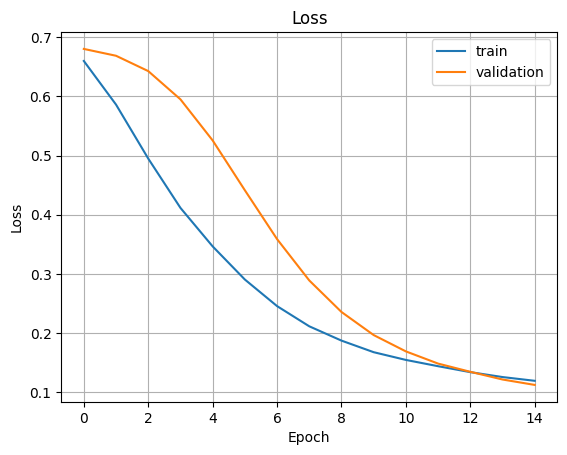

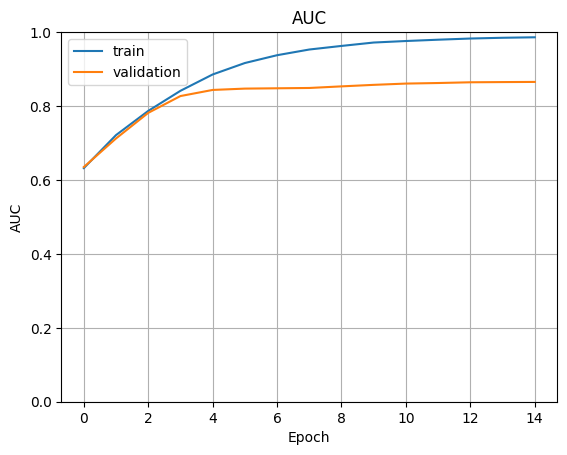

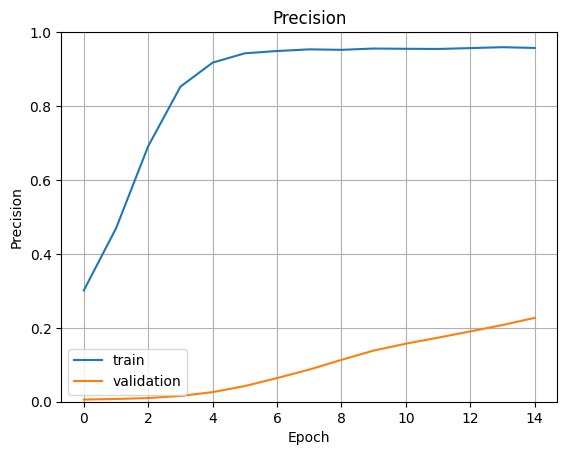

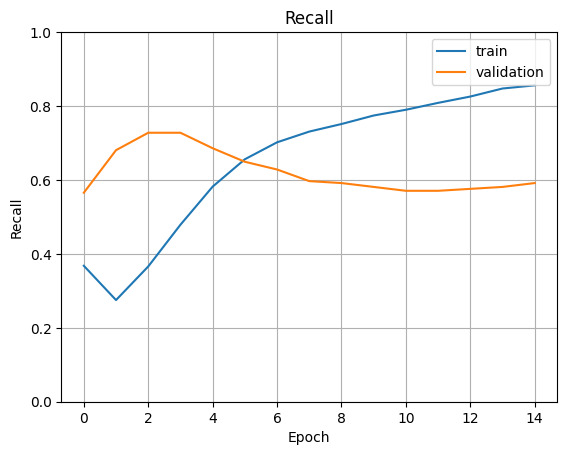

2380/2380 [==============================] - 9s 3ms/step
Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.99      0.99     75668
           1       0.28      0.62      0.39       484

    accuracy                           0.99     76152
   macro avg       0.64      0.80      0.69     76152
weighted avg       0.99      0.99      0.99     76152

Confusion Matrix:


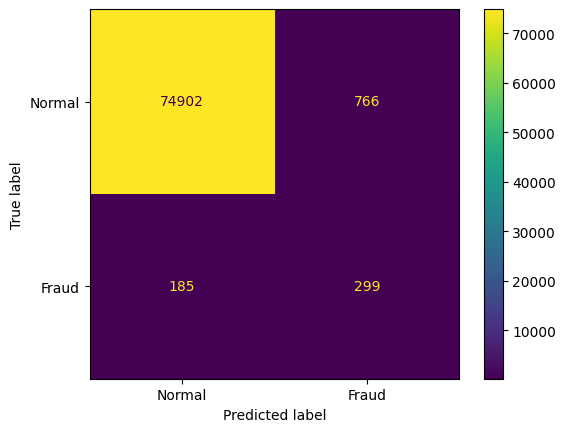

X_train_seq shape: (38855, 5, 29)
y_train_seq shape: (38855,)
X_val_seq shape: (50779, 5, 29)
y_val_seq shape: (50779,)
Epoch 1/15
1215/1215 [==============================] - 21s 12ms/step - loss: 0.6677 - accuracy: 0.6930 - precision: 0.2369 - recall: 0.2409 - auc: 0.5311 - val_loss: 0.6325 - val_accuracy: 0.9426 - val_precision: 0.0201 - val_recall: 0.2984 - val_auc: 0.6450
Epoch 2/15
1215/1215 [==============================] - 14s 12ms/step - loss: 0.5437 - accuracy: 0.8884 - precision: 0.8837 - recall: 0.5092 - auc: 0.8467 - val_loss: 0.4595 - val_accuracy: 0.9907 - val_precision: 0.1759 - val_recall: 0.3979 - val_auc: 0.7577
Epoch 3/15
1215/1215 [==============================] - 13s 11ms/step - loss: 0.3468 - accuracy: 0.9172 - precision: 0.9643 - recall: 0.6083 - auc: 0.9005 - val_loss: 0.2038 - val_accuracy: 0.9967 - val_precision: 0.5887 - val_recall: 0.3822 - val_auc: 0.7778
Epoch 4/15
1215/1215 [==============================] - 13s 11ms/step - loss: 0.2323 - accuracy: 0.9

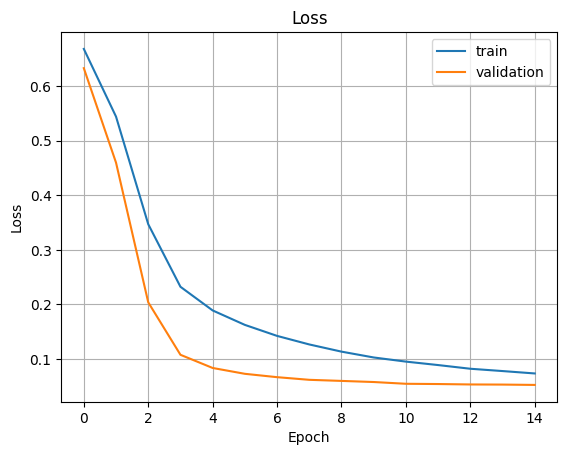

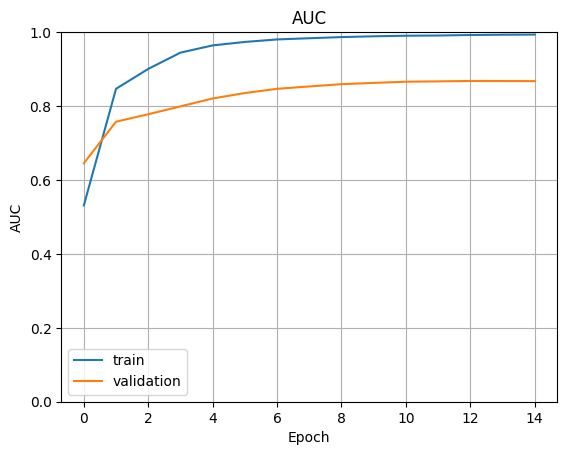

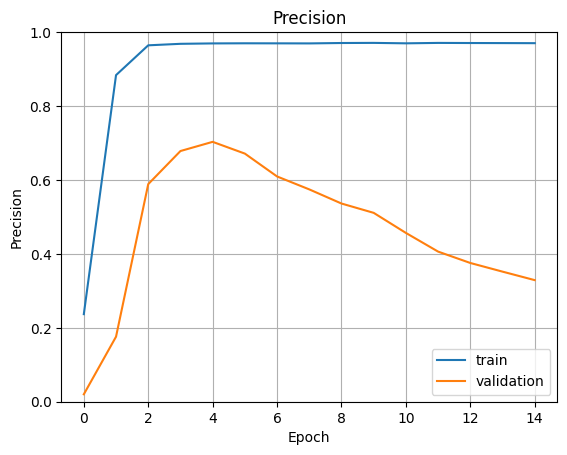

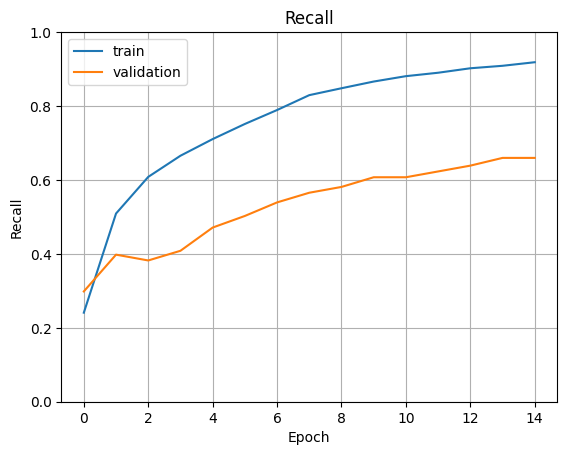

2380/2380 [==============================] - 9s 3ms/step
Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.99      1.00     75668
           1       0.44      0.73      0.55       484

    accuracy                           0.99     76152
   macro avg       0.72      0.86      0.77     76152
weighted avg       0.99      0.99      0.99     76152

Confusion Matrix:


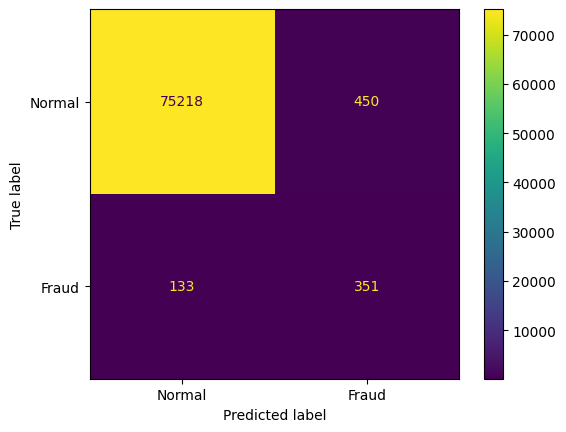

X_train_seq shape: (58316, 5, 29)
y_train_seq shape: (58316,)
X_val_seq shape: (50779, 5, 29)
y_val_seq shape: (50779,)
Epoch 1/15
1823/1823 [==============================] - 26s 11ms/step - loss: 0.6205 - accuracy: 0.8449 - precision: 0.5902 - recall: 0.7350 - auc: 0.8776 - val_loss: 0.5440 - val_accuracy: 0.9808 - val_precision: 0.1014 - val_recall: 0.5236 - val_auc: 0.8200
Epoch 2/15
1823/1823 [==============================] - 19s 10ms/step - loss: 0.3279 - accuracy: 0.9408 - precision: 0.9732 - recall: 0.7237 - auc: 0.9337 - val_loss: 0.1830 - val_accuracy: 0.9960 - val_precision: 0.4639 - val_recall: 0.4712 - val_auc: 0.8152
Epoch 3/15
1823/1823 [==============================] - 19s 10ms/step - loss: 0.1810 - accuracy: 0.9421 - precision: 0.9770 - recall: 0.7276 - auc: 0.9681 - val_loss: 0.1071 - val_accuracy: 0.9965 - val_precision: 0.5389 - val_recall: 0.5079 - val_auc: 0.8358
Epoch 4/15
1823/1823 [==============================] - 19s 10ms/step - loss: 0.1450 - accuracy: 0.9

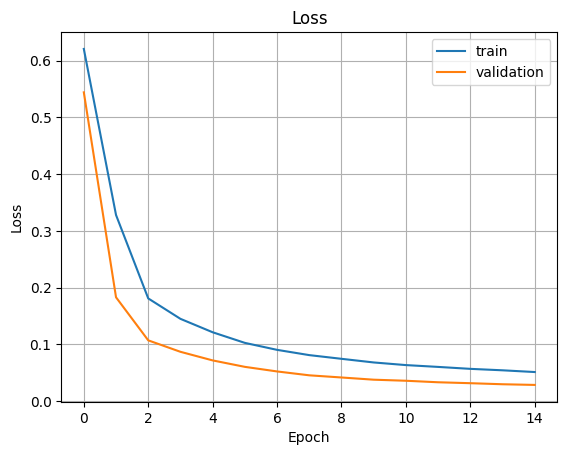

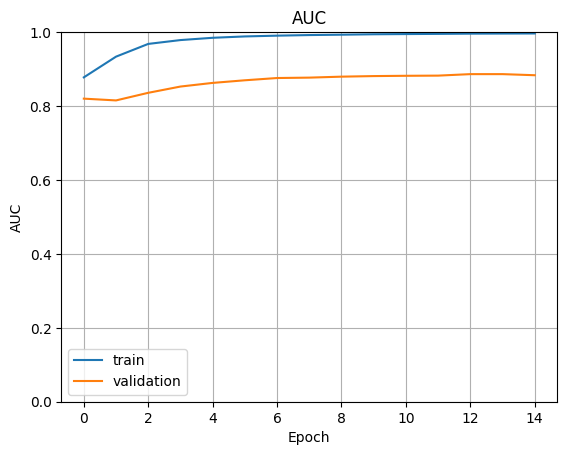

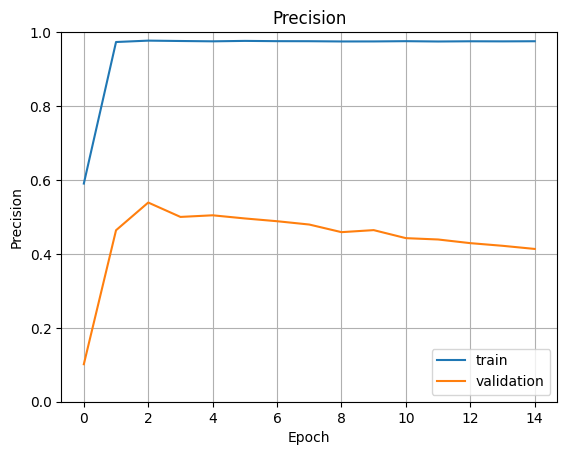

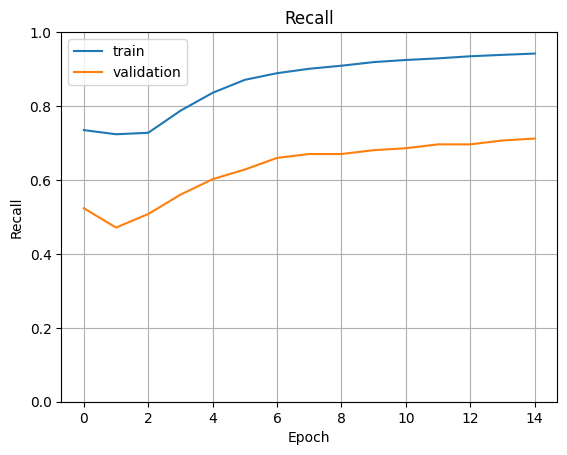

2380/2380 [==============================] - 9s 3ms/step
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     75668
           1       0.59      0.75      0.66       484

    accuracy                           1.00     76152
   macro avg       0.79      0.88      0.83     76152
weighted avg       1.00      1.00      1.00     76152

Confusion Matrix:


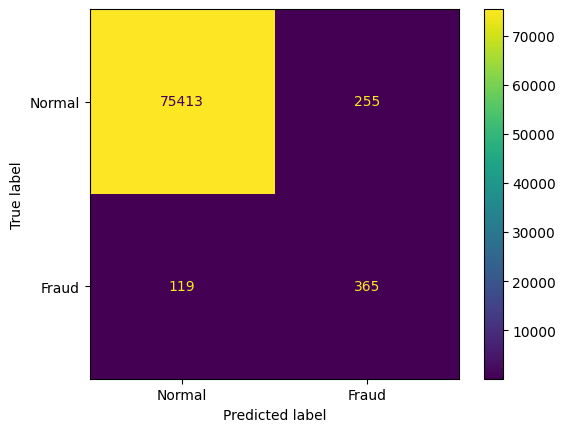

X_train_seq shape: (77937, 5, 29)
y_train_seq shape: (77937,)
X_val_seq shape: (50779, 5, 29)
y_val_seq shape: (50779,)
Epoch 1/15
2436/2436 [==============================] - 31s 10ms/step - loss: 0.5999 - accuracy: 0.8059 - precision: 0.5137 - recall: 0.5569 - auc: 0.8095 - val_loss: 0.4808 - val_accuracy: 0.9704 - val_precision: 0.0645 - val_recall: 0.5079 - val_auc: 0.7949
Epoch 2/15
2436/2436 [==============================] - 24s 10ms/step - loss: 0.2712 - accuracy: 0.9266 - precision: 0.9764 - recall: 0.6486 - auc: 0.9238 - val_loss: 0.1708 - val_accuracy: 0.9930 - val_precision: 0.2670 - val_recall: 0.4921 - val_auc: 0.8280
Epoch 3/15
2436/2436 [==============================] - 24s 10ms/step - loss: 0.1873 - accuracy: 0.9404 - precision: 0.9786 - recall: 0.7175 - auc: 0.9566 - val_loss: 0.1377 - val_accuracy: 0.9935 - val_precision: 0.3023 - val_recall: 0.5602 - val_auc: 0.8499
Epoch 4/15
2436/2436 [==============================] - 24s 10ms/step - loss: 0.1547 - accuracy: 0.9

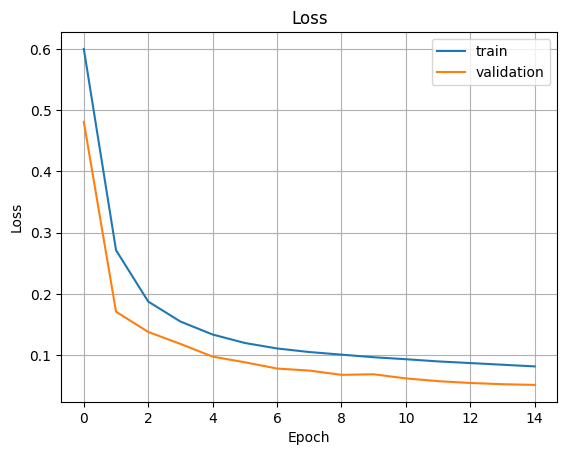

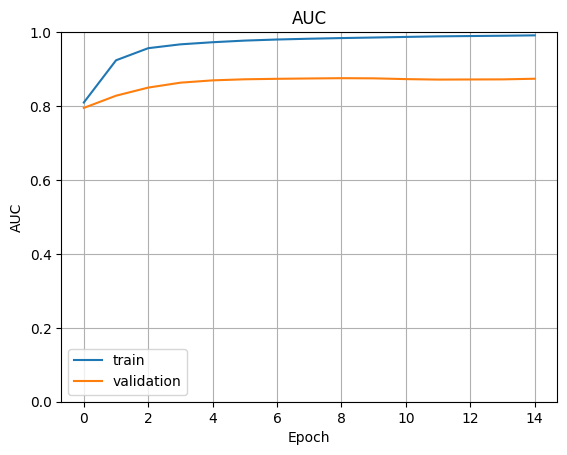

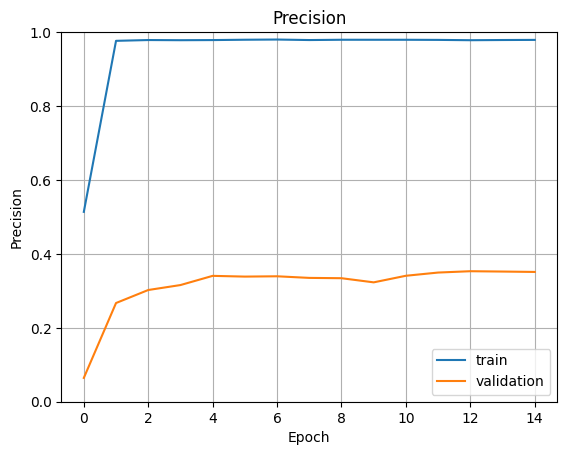

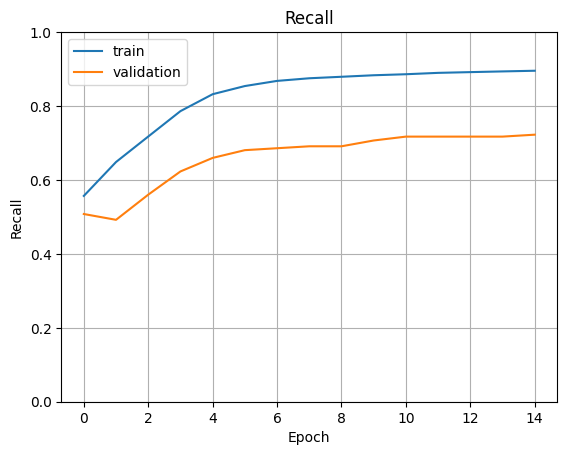

2380/2380 [==============================] - 9s 3ms/step
Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.99      1.00     75668
           1       0.47      0.76      0.58       484

    accuracy                           0.99     76152
   macro avg       0.73      0.88      0.79     76152
weighted avg       1.00      0.99      0.99     76152

Confusion Matrix:


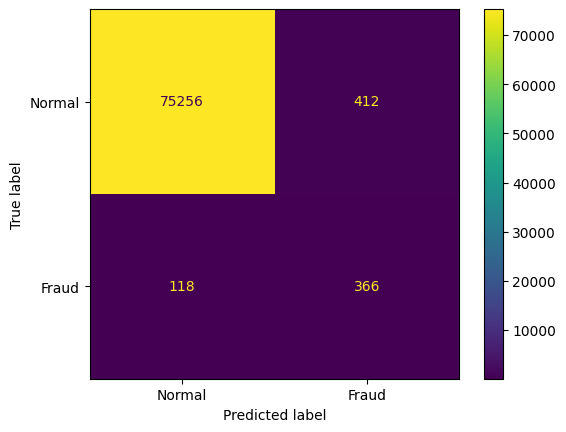

X_train_seq shape: (97502, 5, 29)
y_train_seq shape: (97502,)
X_val_seq shape: (50779, 5, 29)
y_val_seq shape: (50779,)
Epoch 1/15
3047/3047 [==============================] - 36s 10ms/step - loss: 0.5445 - accuracy: 0.8595 - precision: 0.6501 - recall: 0.6448 - auc: 0.8566 - val_loss: 0.3690 - val_accuracy: 0.9681 - val_precision: 0.0565 - val_recall: 0.4764 - val_auc: 0.7859
Epoch 2/15
3047/3047 [==============================] - 28s 9ms/step - loss: 0.2194 - accuracy: 0.9319 - precision: 0.9827 - recall: 0.6712 - auc: 0.9414 - val_loss: 0.1945 - val_accuracy: 0.9833 - val_precision: 0.1231 - val_recall: 0.5602 - val_auc: 0.8214
Epoch 3/15
3047/3047 [==============================] - 29s 9ms/step - loss: 0.1629 - accuracy: 0.9515 - precision: 0.9836 - recall: 0.7701 - auc: 0.9614 - val_loss: 0.1540 - val_accuracy: 0.9871 - val_precision: 0.1674 - val_recall: 0.6126 - val_auc: 0.8445
Epoch 4/15
3047/3047 [==============================] - 28s 9ms/step - loss: 0.1352 - accuracy: 0.9636

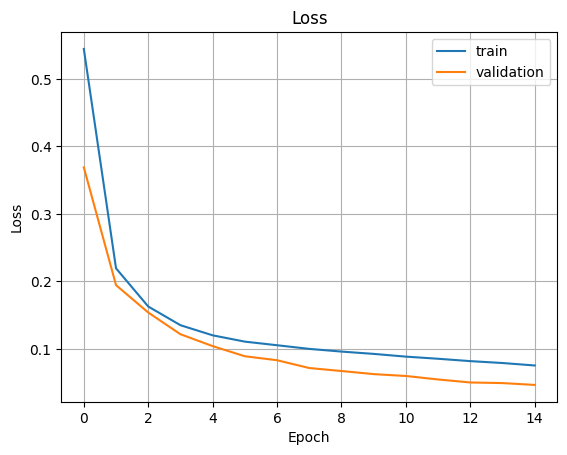

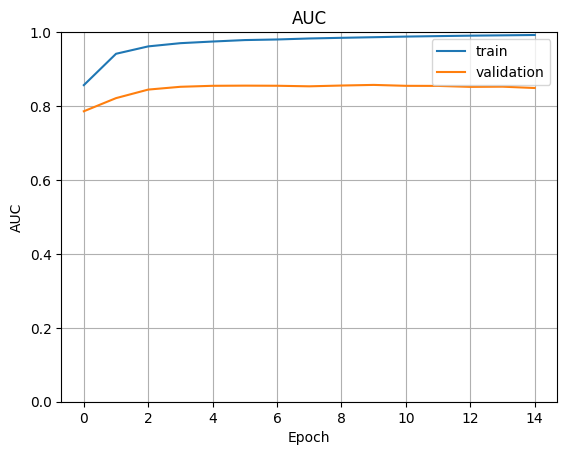

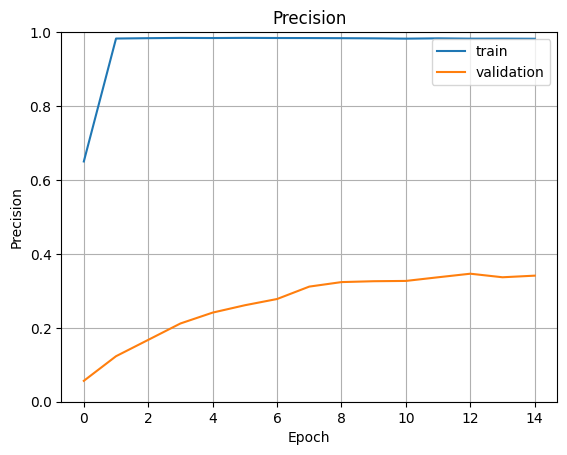

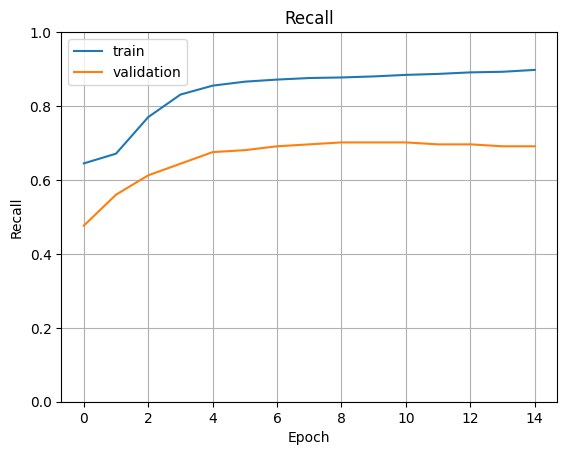

2380/2380 [==============================] - 9s 3ms/step
Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.99      1.00     75668
           1       0.46      0.75      0.57       484

    accuracy                           0.99     76152
   macro avg       0.73      0.87      0.79     76152
weighted avg       1.00      0.99      0.99     76152

Confusion Matrix:


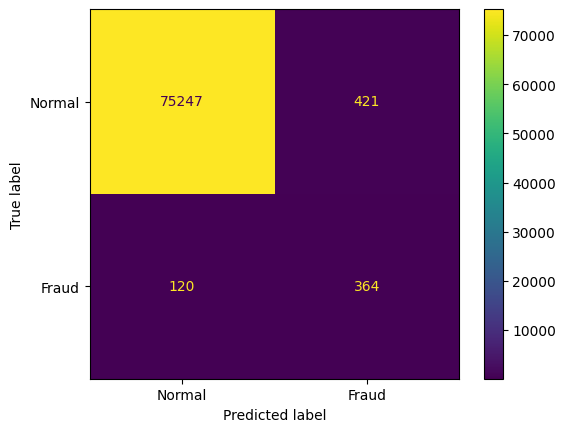

X_train_seq shape: (117072, 5, 29)
y_train_seq shape: (117072,)
X_val_seq shape: (50779, 5, 29)
y_val_seq shape: (50779,)
Epoch 1/15
3659/3659 [==============================] - 41s 9ms/step - loss: 0.5017 - accuracy: 0.8810 - precision: 0.7033 - recall: 0.7004 - auc: 0.8742 - val_loss: 0.1551 - val_accuracy: 0.9968 - val_precision: 0.6084 - val_recall: 0.4555 - val_auc: 0.8411
Epoch 2/15
3659/3659 [==============================] - 33s 9ms/step - loss: 0.1984 - accuracy: 0.9378 - precision: 0.9820 - recall: 0.7021 - auc: 0.9470 - val_loss: 0.0834 - val_accuracy: 0.9961 - val_precision: 0.4823 - val_recall: 0.5707 - val_auc: 0.8641
Epoch 3/15
3659/3659 [==============================] - 33s 9ms/step - loss: 0.1496 - accuracy: 0.9578 - precision: 0.9820 - recall: 0.8037 - auc: 0.9639 - val_loss: 0.0667 - val_accuracy: 0.9951 - val_precision: 0.4040 - val_recall: 0.6283 - val_auc: 0.8736
Epoch 4/15
3659/3659 [==============================] - 33s 9ms/step - loss: 0.1265 - accuracy: 0.966

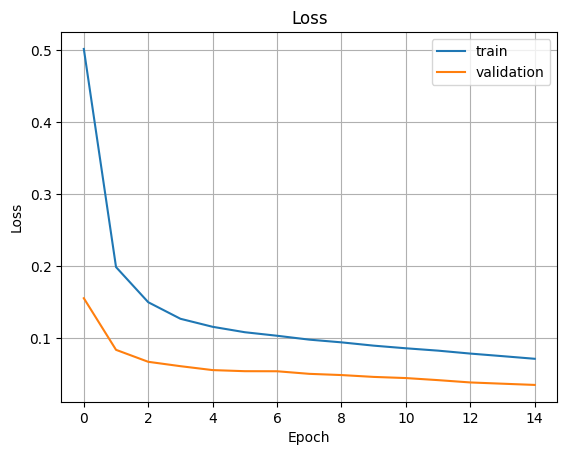

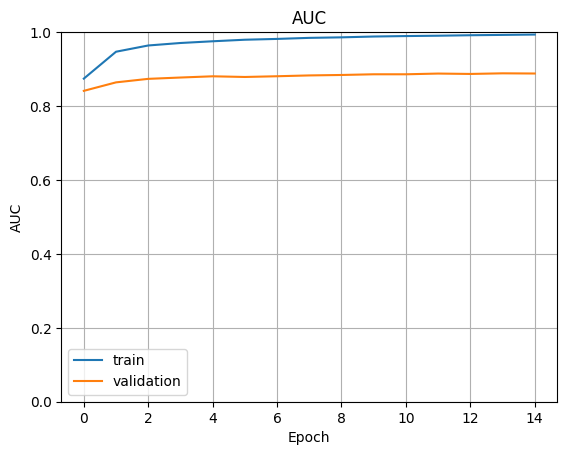

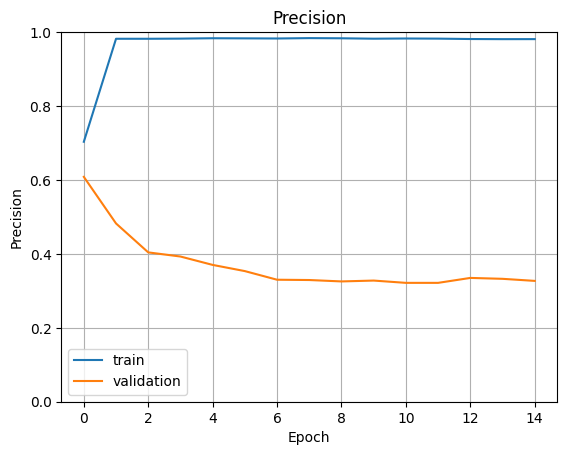

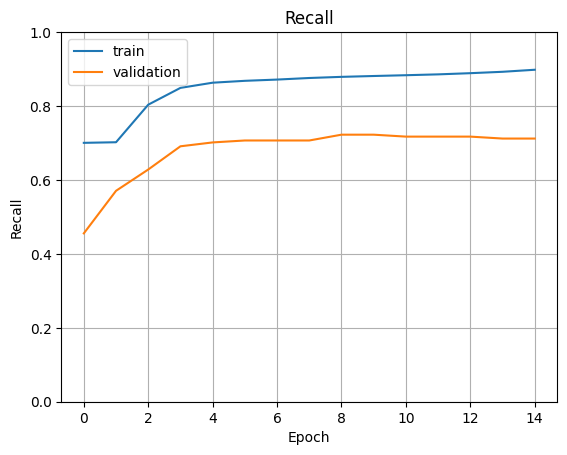

2380/2380 [==============================] - 10s 3ms/step
Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.99      1.00     75668
           1       0.49      0.75      0.59       484

    accuracy                           0.99     76152
   macro avg       0.74      0.87      0.79     76152
weighted avg       1.00      0.99      0.99     76152

Confusion Matrix:


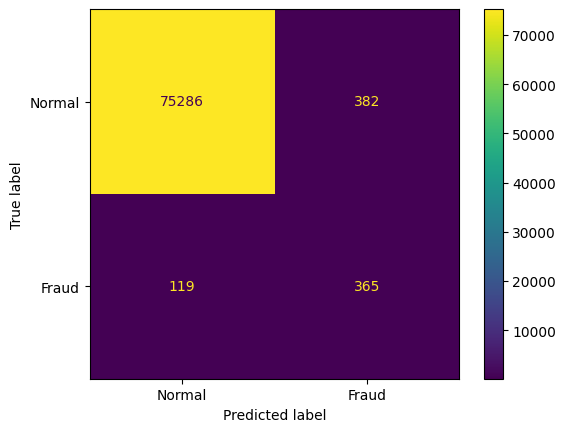

X_train_seq shape: (136692, 5, 29)
y_train_seq shape: (136692,)
X_val_seq shape: (50779, 5, 29)
y_val_seq shape: (50779,)
Epoch 1/15
4272/4272 [==============================] - 46s 9ms/step - loss: 0.4573 - accuracy: 0.8701 - precision: 0.7024 - recall: 0.6077 - auc: 0.8440 - val_loss: 0.1611 - val_accuracy: 0.9963 - val_precision: 0.5089 - val_recall: 0.4503 - val_auc: 0.8308
Epoch 2/15
4272/4272 [==============================] - 38s 9ms/step - loss: 0.1944 - accuracy: 0.9422 - precision: 0.9881 - recall: 0.7198 - auc: 0.9456 - val_loss: 0.1105 - val_accuracy: 0.9956 - val_precision: 0.4346 - val_recall: 0.5916 - val_auc: 0.8696
Epoch 3/15
4272/4272 [==============================] - 38s 9ms/step - loss: 0.1512 - accuracy: 0.9585 - precision: 0.9868 - recall: 0.8032 - auc: 0.9623 - val_loss: 0.0905 - val_accuracy: 0.9944 - val_precision: 0.3668 - val_recall: 0.6702 - val_auc: 0.8798
Epoch 4/15
4272/4272 [==============================] - 37s 9ms/step - loss: 0.1325 - accuracy: 0.963

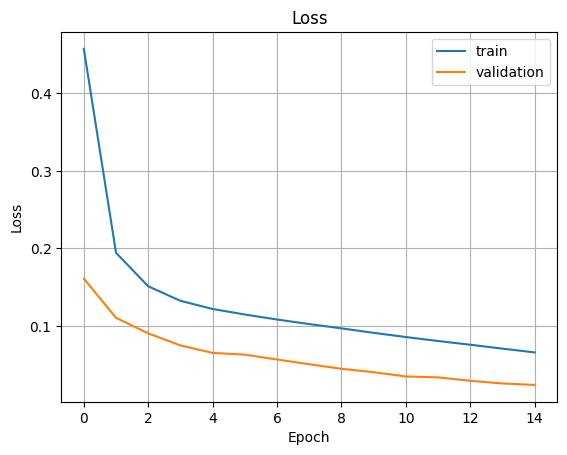

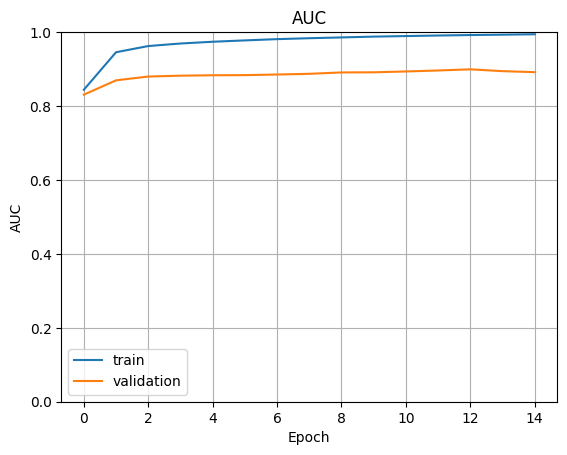

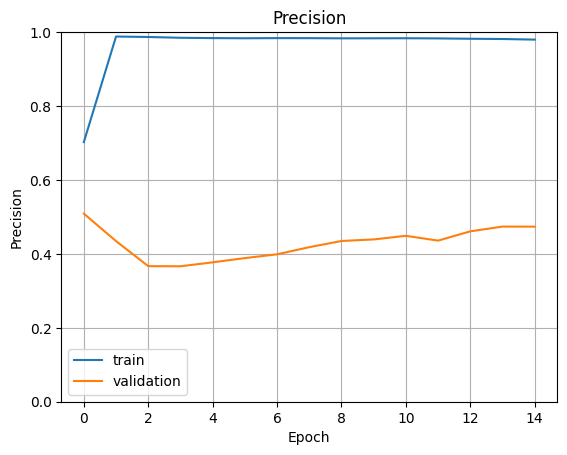

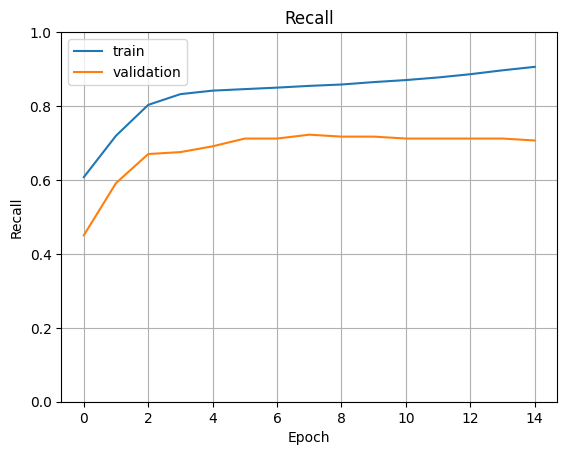

2380/2380 [==============================] - 10s 4ms/step
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     75668
           1       0.67      0.75      0.70       484

    accuracy                           1.00     76152
   macro avg       0.83      0.87      0.85     76152
weighted avg       1.00      1.00      1.00     76152

Confusion Matrix:


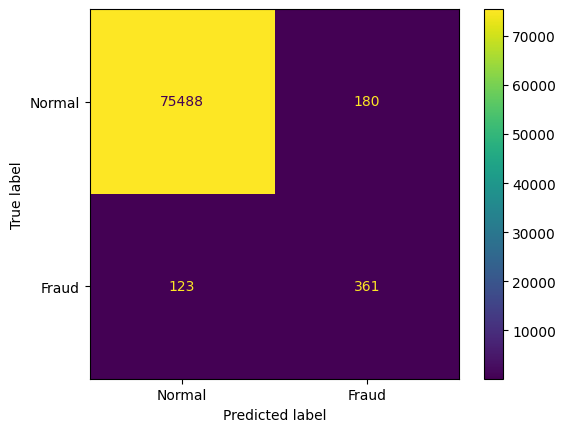

X_train_seq shape: (156295, 5, 29)
y_train_seq shape: (156295,)
X_val_seq shape: (50779, 5, 29)
y_val_seq shape: (50779,)
Epoch 1/15
4885/4885 [==============================] - 50s 9ms/step - loss: 0.4450 - accuracy: 0.8771 - precision: 0.7140 - recall: 0.6430 - auc: 0.8397 - val_loss: 0.1031 - val_accuracy: 0.9970 - val_precision: 0.6532 - val_recall: 0.4241 - val_auc: 0.8346
Epoch 2/15
4885/4885 [==============================] - 42s 9ms/step - loss: 0.2043 - accuracy: 0.9365 - precision: 0.9840 - recall: 0.6938 - auc: 0.9387 - val_loss: 0.0822 - val_accuracy: 0.9953 - val_precision: 0.4122 - val_recall: 0.5654 - val_auc: 0.8547
Epoch 3/15
4885/4885 [==============================] - 42s 9ms/step - loss: 0.1627 - accuracy: 0.9529 - precision: 0.9796 - recall: 0.7809 - auc: 0.9557 - val_loss: 0.0720 - val_accuracy: 0.9939 - val_precision: 0.3352 - val_recall: 0.6387 - val_auc: 0.8689
Epoch 4/15
4885/4885 [==============================] - 42s 9ms/step - loss: 0.1433 - accuracy: 0.959

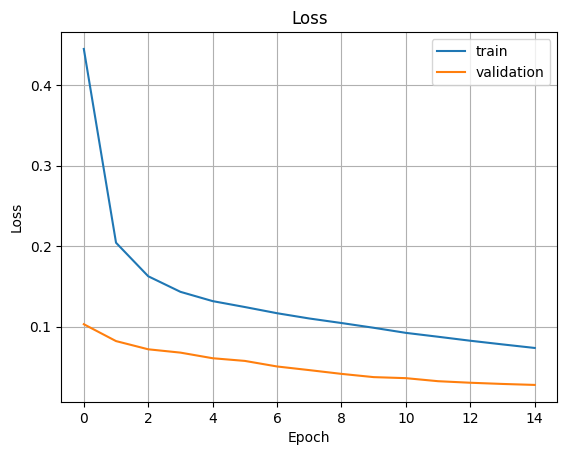

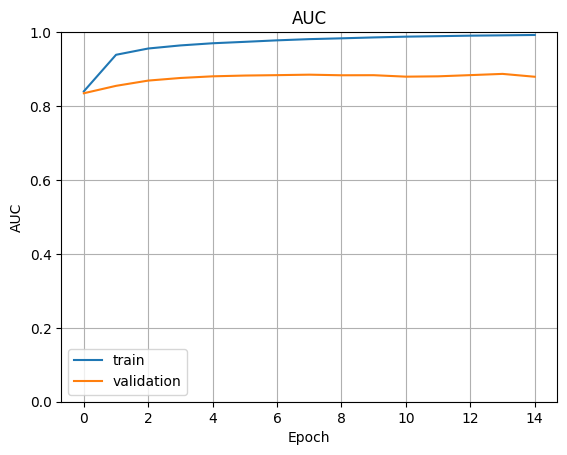

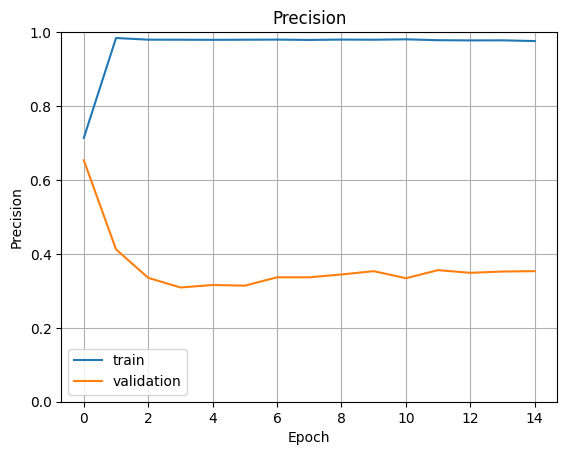

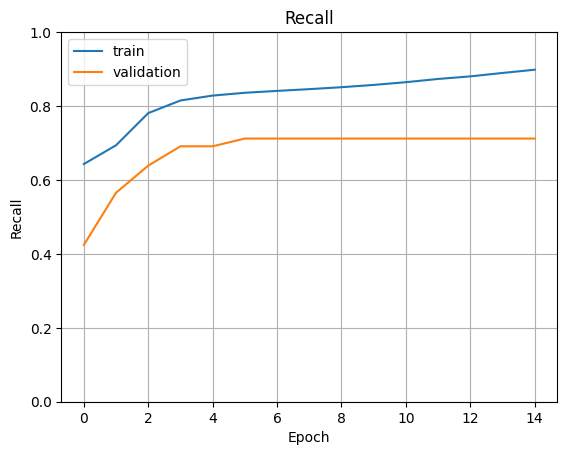

2380/2380 [==============================] - 9s 3ms/step
Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.99      1.00     75668
           1       0.49      0.76      0.60       484

    accuracy                           0.99     76152
   macro avg       0.74      0.88      0.80     76152
weighted avg       1.00      0.99      0.99     76152

Confusion Matrix:


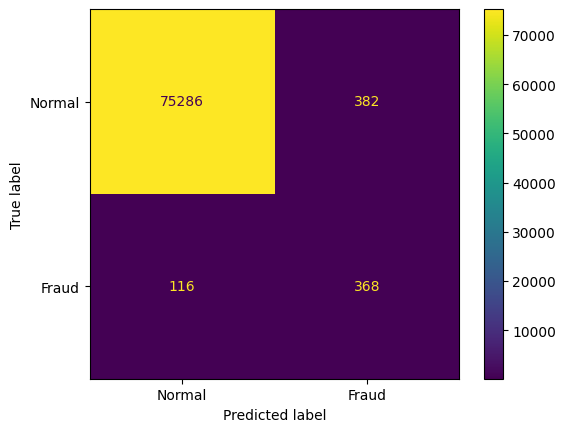

X_train_seq shape: (175987, 5, 29)
y_train_seq shape: (175987,)
X_val_seq shape: (50779, 5, 29)
y_val_seq shape: (50779,)
Epoch 1/15
5500/5500 [==============================] - 55s 9ms/step - loss: 0.4298 - accuracy: 0.8659 - precision: 0.7098 - recall: 0.5572 - auc: 0.8299 - val_loss: 0.1196 - val_accuracy: 0.9965 - val_precision: 0.5380 - val_recall: 0.5183 - val_auc: 0.8442
Epoch 2/15
5500/5500 [==============================] - 47s 9ms/step - loss: 0.1960 - accuracy: 0.9393 - precision: 0.9789 - recall: 0.7117 - auc: 0.9456 - val_loss: 0.0950 - val_accuracy: 0.9932 - val_precision: 0.3058 - val_recall: 0.6387 - val_auc: 0.8642
Epoch 3/15
5500/5500 [==============================] - 47s 9ms/step - loss: 0.1521 - accuracy: 0.9572 - precision: 0.9781 - recall: 0.8040 - auc: 0.9614 - val_loss: 0.0734 - val_accuracy: 0.9935 - val_precision: 0.3293 - val_recall: 0.7120 - val_auc: 0.8674
Epoch 4/15
5500/5500 [==============================] - 52s 9ms/step - loss: 0.1331 - accuracy: 0.962

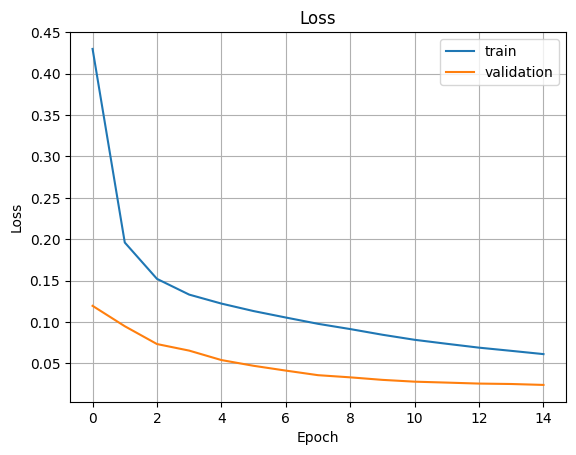

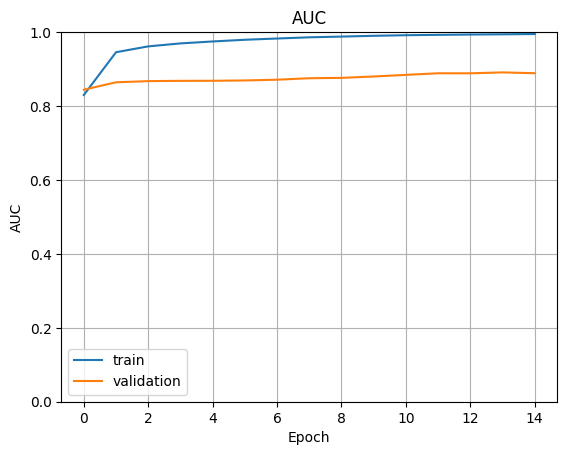

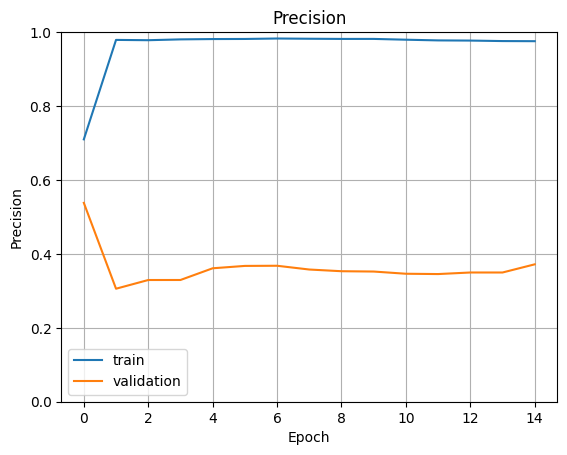

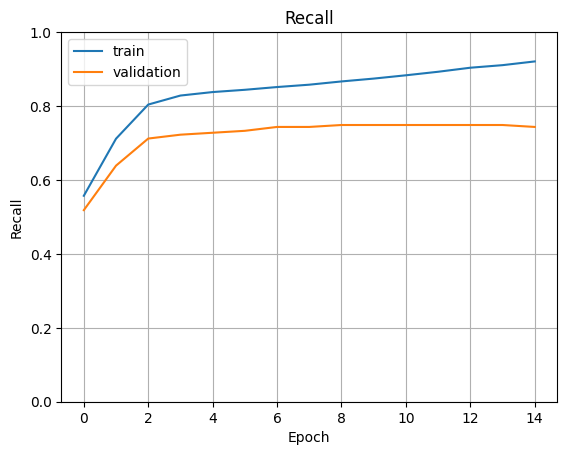

2380/2380 [==============================] - 9s 3ms/step
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     75668
           1       0.56      0.76      0.64       484

    accuracy                           0.99     76152
   macro avg       0.78      0.88      0.82     76152
weighted avg       1.00      0.99      1.00     76152

Confusion Matrix:


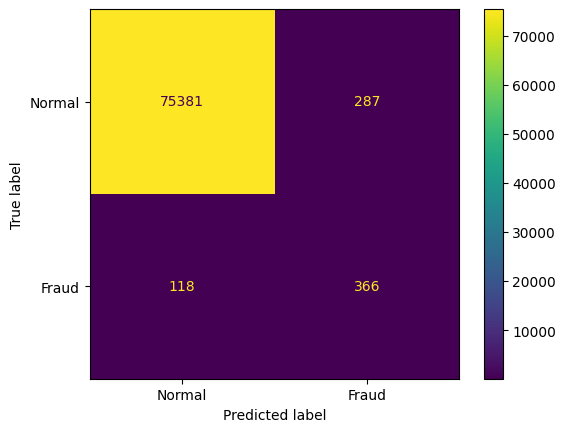

X_train_seq shape: (195317, 5, 29)
y_train_seq shape: (195317,)
X_val_seq shape: (50779, 5, 29)
y_val_seq shape: (50779,)
Epoch 1/15
6104/6104 [==============================] - 58s 9ms/step - loss: 0.4223 - accuracy: 0.8680 - precision: 0.7489 - recall: 0.5117 - auc: 0.8309 - val_loss: 0.0784 - val_accuracy: 0.9974 - val_precision: 0.7398 - val_recall: 0.4764 - val_auc: 0.8561
Epoch 2/15
6104/6104 [==============================] - 50s 8ms/step - loss: 0.1881 - accuracy: 0.9429 - precision: 0.9816 - recall: 0.7281 - auc: 0.9465 - val_loss: 0.0660 - val_accuracy: 0.9961 - val_precision: 0.4863 - val_recall: 0.6492 - val_auc: 0.8901
Epoch 3/15
6104/6104 [==============================] - 51s 8ms/step - loss: 0.1502 - accuracy: 0.9578 - precision: 0.9792 - recall: 0.8061 - auc: 0.9601 - val_loss: 0.0658 - val_accuracy: 0.9947 - val_precision: 0.3895 - val_recall: 0.7016 - val_auc: 0.8969
Epoch 4/15
6104/6104 [==============================] - 51s 8ms/step - loss: 0.1340 - accuracy: 0.962

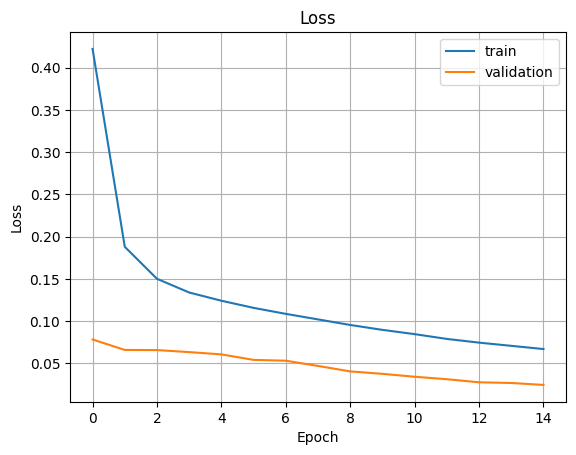

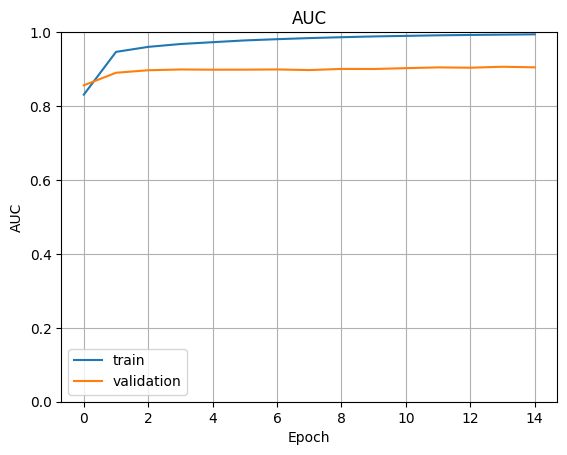

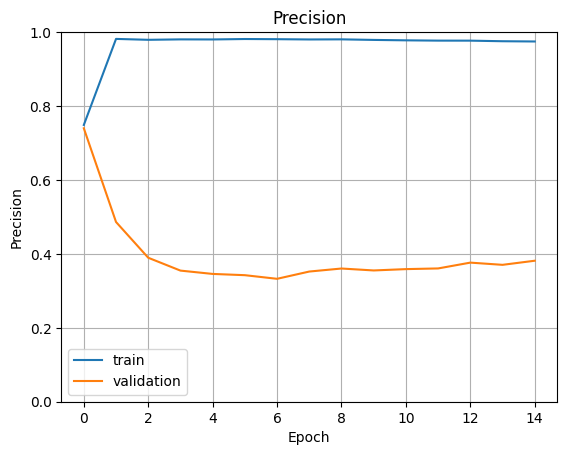

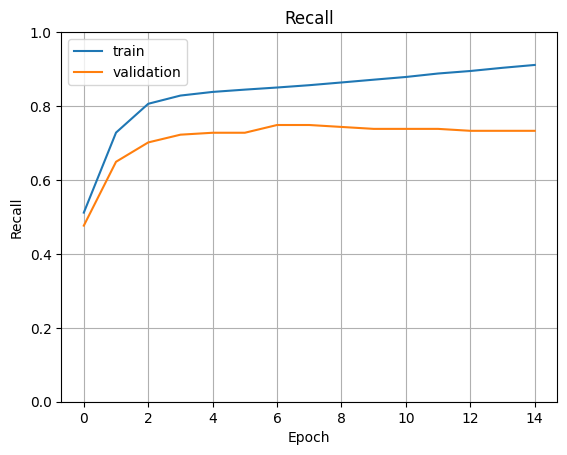

2380/2380 [==============================] - 10s 3ms/step
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     75668
           1       0.56      0.77      0.64       484

    accuracy                           0.99     76152
   macro avg       0.78      0.88      0.82     76152
weighted avg       1.00      0.99      1.00     76152

Confusion Matrix:


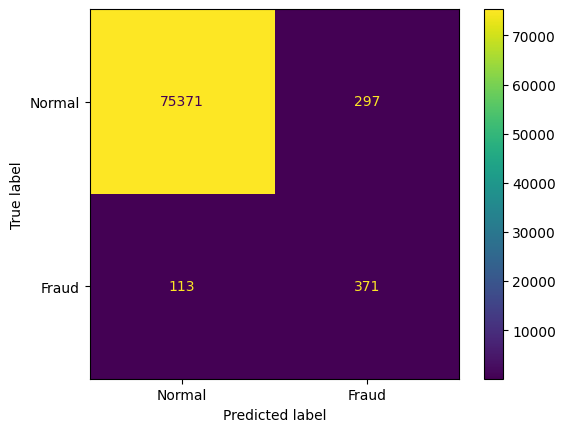

In [49]:
models = []
hists = []
for X_train_seq, y_train_seq in zip(X_train_seq_datasets, y_train_seq_datasets):
    print(f'X_train_seq shape: {X_train_seq.shape}')
    print(f'y_train_seq shape: {y_train_seq.shape}')
    print(f'X_val_seq shape: {X_val_seq.shape}')
    print(f'y_val_seq shape: {y_val_seq.shape}')
    model, hist = train_and_plot_results(X_train_seq, y_train_seq, X_test_seq, y_test_seq, best_hp, X_val=X_val_seq, y_val=y_val_seq)
    models.append(model)
    hists.append(hist)


494/494 [==============================] - 1s 3ms/step


c:\users\albert salles\documents\personal\mtu\privacy\tensorflow_privacy\privacy\privacy_tests\epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
c:\users\albert salles\documents\personal\mtu\privacy\tensorflow_privacy\privacy\privacy_tests\epsilon_lower_bound.py:335: RuntimeWarning: divide by zero encountered in divide
  (self._z**2 * fnr * tnr) /
c:\users\albert salles\documents\personal\mtu\privacy\tensorflow_privacy\privacy\privacy_tests\epsilon_lower_bound.py:334: RuntimeWarning: invalid value encountered in subtract
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
c:\users\albert salles\documents\personal\mtu\privacy\tensorflow_privacy\privacy\privacy_tests\epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
c:\users\albert salles\documents\personal\mtu\privacy

494/494 [==============================] - 1s 3ms/step


c:\users\albert salles\documents\personal\mtu\privacy\tensorflow_privacy\privacy\privacy_tests\epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
c:\users\albert salles\documents\personal\mtu\privacy\tensorflow_privacy\privacy\privacy_tests\epsilon_lower_bound.py:335: RuntimeWarning: divide by zero encountered in divide
  (self._z**2 * fnr * tnr) /
c:\users\albert salles\documents\personal\mtu\privacy\tensorflow_privacy\privacy\privacy_tests\epsilon_lower_bound.py:334: RuntimeWarning: invalid value encountered in subtract
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
c:\users\albert salles\documents\personal\mtu\privacy\tensorflow_privacy\privacy\privacy_tests\epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
c:\users\albert salles\documents\personal\mtu\privacy

 18/494 [>.............................] - ETA: 1s 

c:\users\albert salles\documents\personal\mtu\privacy\tensorflow_privacy\privacy\privacy_tests\epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
c:\users\albert salles\documents\personal\mtu\privacy\tensorflow_privacy\privacy\privacy_tests\epsilon_lower_bound.py:335: RuntimeWarning: divide by zero encountered in divide
  (self._z**2 * fnr * tnr) /
c:\users\albert salles\documents\personal\mtu\privacy\tensorflow_privacy\privacy\privacy_tests\epsilon_lower_bound.py:334: RuntimeWarning: invalid value encountered in subtract
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -


494/494 [==============================] - 2s 3ms/step


c:\users\albert salles\documents\personal\mtu\privacy\tensorflow_privacy\privacy\privacy_tests\epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
c:\users\albert salles\documents\personal\mtu\privacy\tensorflow_privacy\privacy\privacy_tests\epsilon_lower_bound.py:335: RuntimeWarning: divide by zero encountered in divide
  (self._z**2 * fnr * tnr) /
c:\users\albert salles\documents\personal\mtu\privacy\tensorflow_privacy\privacy\privacy_tests\epsilon_lower_bound.py:334: RuntimeWarning: invalid value encountered in subtract
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
c:\users\albert salles\documents\personal\mtu\privacy\tensorflow_privacy\privacy\privacy_tests\epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
c:\users\albert salles\documents\personal\mtu\privacy

 18/494 [>.............................] - ETA: 1s 

c:\users\albert salles\documents\personal\mtu\privacy\tensorflow_privacy\privacy\privacy_tests\epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
c:\users\albert salles\documents\personal\mtu\privacy\tensorflow_privacy\privacy\privacy_tests\epsilon_lower_bound.py:335: RuntimeWarning: divide by zero encountered in divide
  (self._z**2 * fnr * tnr) /
c:\users\albert salles\documents\personal\mtu\privacy\tensorflow_privacy\privacy\privacy_tests\epsilon_lower_bound.py:334: RuntimeWarning: invalid value encountered in subtract
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -


494/494 [==============================] - 2s 3ms/step


c:\users\albert salles\documents\personal\mtu\privacy\tensorflow_privacy\privacy\privacy_tests\epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
c:\users\albert salles\documents\personal\mtu\privacy\tensorflow_privacy\privacy\privacy_tests\epsilon_lower_bound.py:335: RuntimeWarning: divide by zero encountered in divide
  (self._z**2 * fnr * tnr) /
c:\users\albert salles\documents\personal\mtu\privacy\tensorflow_privacy\privacy\privacy_tests\epsilon_lower_bound.py:334: RuntimeWarning: invalid value encountered in subtract
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
c:\users\albert salles\documents\personal\mtu\privacy\tensorflow_privacy\privacy\privacy_tests\epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
c:\users\albert salles\documents\personal\mtu\privacy

494/494 [==============================] - 2s 3ms/step


c:\users\albert salles\documents\personal\mtu\privacy\tensorflow_privacy\privacy\privacy_tests\epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
c:\users\albert salles\documents\personal\mtu\privacy\tensorflow_privacy\privacy\privacy_tests\epsilon_lower_bound.py:335: RuntimeWarning: divide by zero encountered in divide
  (self._z**2 * fnr * tnr) /
c:\users\albert salles\documents\personal\mtu\privacy\tensorflow_privacy\privacy\privacy_tests\epsilon_lower_bound.py:334: RuntimeWarning: invalid value encountered in subtract
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
c:\users\albert salles\documents\personal\mtu\privacy\tensorflow_privacy\privacy\privacy_tests\epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
c:\users\albert salles\documents\personal\mtu\privacy

494/494 [==============================] - 1s 3ms/step


c:\users\albert salles\documents\personal\mtu\privacy\tensorflow_privacy\privacy\privacy_tests\epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
c:\users\albert salles\documents\personal\mtu\privacy\tensorflow_privacy\privacy\privacy_tests\epsilon_lower_bound.py:335: RuntimeWarning: divide by zero encountered in divide
  (self._z**2 * fnr * tnr) /
c:\users\albert salles\documents\personal\mtu\privacy\tensorflow_privacy\privacy\privacy_tests\epsilon_lower_bound.py:334: RuntimeWarning: invalid value encountered in subtract
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
c:\users\albert salles\documents\personal\mtu\privacy\tensorflow_privacy\privacy\privacy_tests\epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
c:\users\albert salles\documents\personal\mtu\privacy

 16/494 [..............................] - ETA: 1s 

c:\users\albert salles\documents\personal\mtu\privacy\tensorflow_privacy\privacy\privacy_tests\epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
c:\users\albert salles\documents\personal\mtu\privacy\tensorflow_privacy\privacy\privacy_tests\epsilon_lower_bound.py:335: RuntimeWarning: divide by zero encountered in divide
  (self._z**2 * fnr * tnr) /
c:\users\albert salles\documents\personal\mtu\privacy\tensorflow_privacy\privacy\privacy_tests\epsilon_lower_bound.py:334: RuntimeWarning: invalid value encountered in subtract
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -


494/494 [==============================] - 2s 3ms/step


c:\users\albert salles\documents\personal\mtu\privacy\tensorflow_privacy\privacy\privacy_tests\epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
c:\users\albert salles\documents\personal\mtu\privacy\tensorflow_privacy\privacy\privacy_tests\epsilon_lower_bound.py:335: RuntimeWarning: divide by zero encountered in divide
  (self._z**2 * fnr * tnr) /
c:\users\albert salles\documents\personal\mtu\privacy\tensorflow_privacy\privacy\privacy_tests\epsilon_lower_bound.py:334: RuntimeWarning: invalid value encountered in subtract
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
c:\users\albert salles\documents\personal\mtu\privacy\tensorflow_privacy\privacy\privacy_tests\epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
c:\users\albert salles\documents\personal\mtu\privacy

494/494 [==============================] - 2s 3ms/step


c:\users\albert salles\documents\personal\mtu\privacy\tensorflow_privacy\privacy\privacy_tests\epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
c:\users\albert salles\documents\personal\mtu\privacy\tensorflow_privacy\privacy\privacy_tests\epsilon_lower_bound.py:335: RuntimeWarning: divide by zero encountered in divide
  (self._z**2 * fnr * tnr) /
c:\users\albert salles\documents\personal\mtu\privacy\tensorflow_privacy\privacy\privacy_tests\epsilon_lower_bound.py:334: RuntimeWarning: invalid value encountered in subtract
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
c:\users\albert salles\documents\personal\mtu\privacy\tensorflow_privacy\privacy\privacy_tests\epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
c:\users\albert salles\documents\personal\mtu\privacy

 17/494 [>.............................] - ETA: 1s 

c:\users\albert salles\documents\personal\mtu\privacy\tensorflow_privacy\privacy\privacy_tests\epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
c:\users\albert salles\documents\personal\mtu\privacy\tensorflow_privacy\privacy\privacy_tests\epsilon_lower_bound.py:335: RuntimeWarning: divide by zero encountered in divide
  (self._z**2 * fnr * tnr) /
c:\users\albert salles\documents\personal\mtu\privacy\tensorflow_privacy\privacy\privacy_tests\epsilon_lower_bound.py:334: RuntimeWarning: invalid value encountered in subtract
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -


494/494 [==============================] - 2s 3ms/step


c:\users\albert salles\documents\personal\mtu\privacy\tensorflow_privacy\privacy\privacy_tests\epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
c:\users\albert salles\documents\personal\mtu\privacy\tensorflow_privacy\privacy\privacy_tests\epsilon_lower_bound.py:335: RuntimeWarning: divide by zero encountered in divide
  (self._z**2 * fnr * tnr) /
c:\users\albert salles\documents\personal\mtu\privacy\tensorflow_privacy\privacy\privacy_tests\epsilon_lower_bound.py:334: RuntimeWarning: invalid value encountered in subtract
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
c:\users\albert salles\documents\personal\mtu\privacy\tensorflow_privacy\privacy\privacy_tests\epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
c:\users\albert salles\documents\personal\mtu\privacy

494/494 [==============================] - 2s 4ms/step


c:\users\albert salles\documents\personal\mtu\privacy\tensorflow_privacy\privacy\privacy_tests\epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
c:\users\albert salles\documents\personal\mtu\privacy\tensorflow_privacy\privacy\privacy_tests\epsilon_lower_bound.py:335: RuntimeWarning: divide by zero encountered in divide
  (self._z**2 * fnr * tnr) /
c:\users\albert salles\documents\personal\mtu\privacy\tensorflow_privacy\privacy\privacy_tests\epsilon_lower_bound.py:334: RuntimeWarning: invalid value encountered in subtract
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
c:\users\albert salles\documents\personal\mtu\privacy\tensorflow_privacy\privacy\privacy_tests\epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
c:\users\albert salles\documents\personal\mtu\privacy

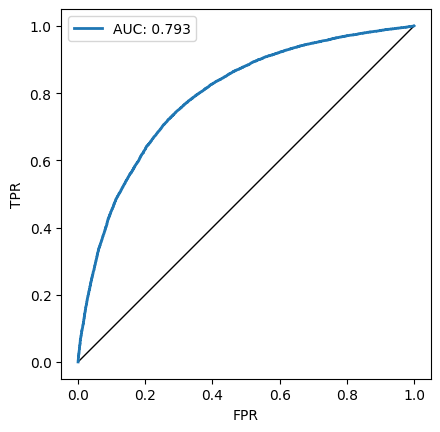

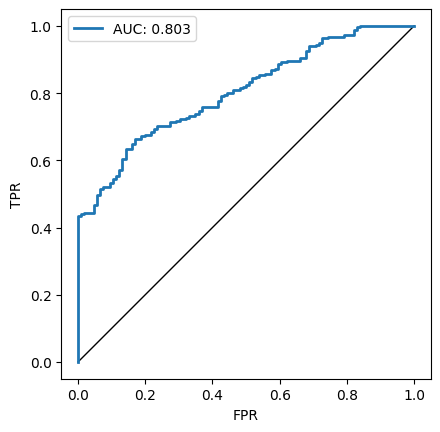

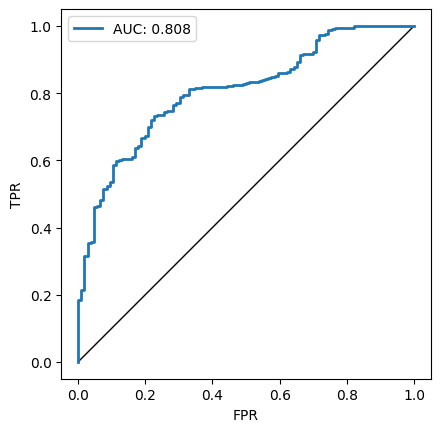

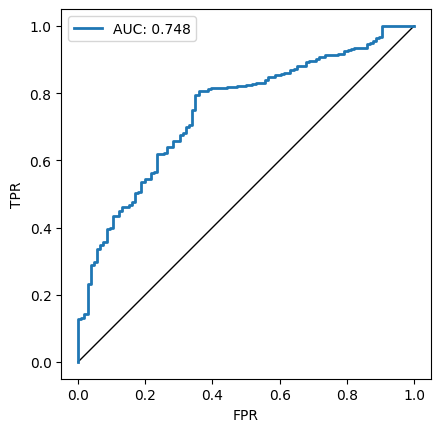

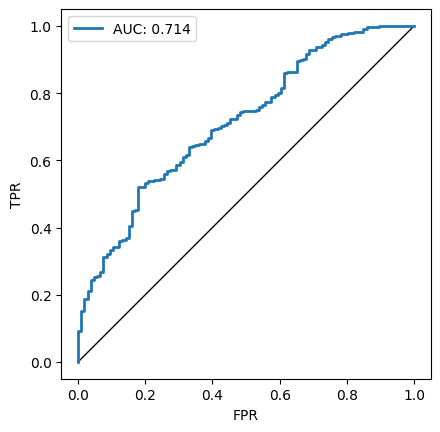

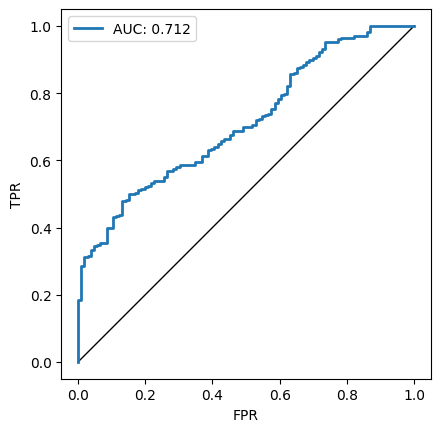

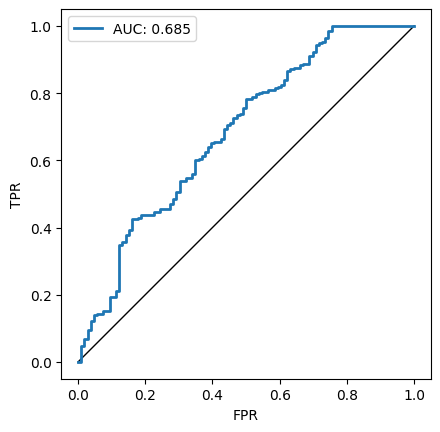

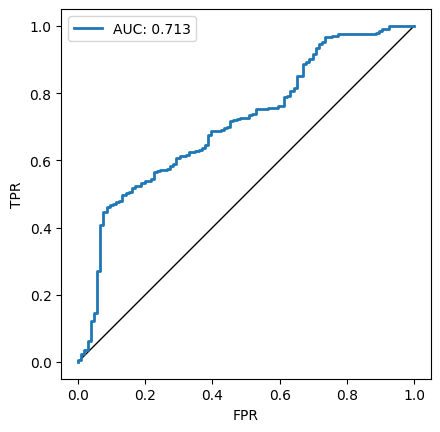

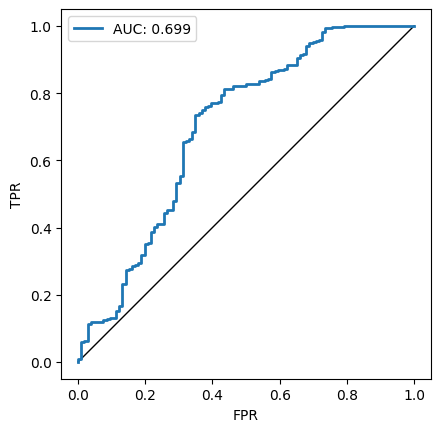

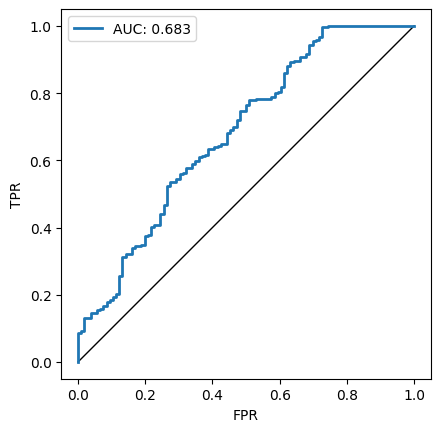

In [74]:
from services.eval_privacy import compute_mia_attacks

attacks_results_list = []
figure_list = []
for i, model in enumerate(models):
    n_rows = X_train_seq_datasets_original[0].shape[0]
    attacks_result, figure = compute_mia_attacks(model, X_train_seq_datasets_original[0], X_test_seq[:n_rows], y_train_seq_datasets_original[0], y_test_seq[:n_rows])    
    attacks_results_list.append(attacks_result)
    figure_list.append(figure)

In [76]:
from sklearn.metrics import classification_report

classification_reports = []
for model, X_train_seq, y_train_seq in zip(models, X_train_seq_datasets, y_train_seq_datasets):
    y_pred = model.predict(X_test_seq)
    cr = classification_report(y_test_seq, y_pred > 0.5, output_dict=True)
    classification_reports.append(cr)

2380/2380 [==============================] - 7s 3ms/step


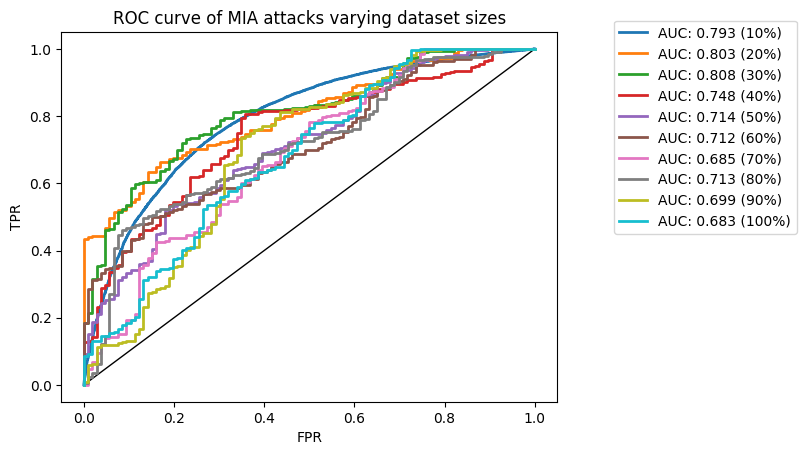

In [75]:
import matplotlib.pyplot as plt
from sklearn import metrics


fig = plt.figure()
plt.plot([0, 1], [0, 1], 'k', lw=1.0)

auc_scores = []

for i, attacks_result in enumerate(attacks_results_list):
    x = attacks_result.get_result_with_max_auc().roc_curve.fpr
    y = attacks_result.get_result_with_max_auc().roc_curve.tpr
    auc = metrics.auc(x, y)
    auc_scores.append(auc)
    plt.plot(x, y, lw=2, label=f'AUC: {auc:.3f} ({(i+1)*10}%)')
plt.title('ROC curve of MIA attacks varying dataset sizes')
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.legend(bbox_to_anchor=(1.1, 1.05))
plt.show()

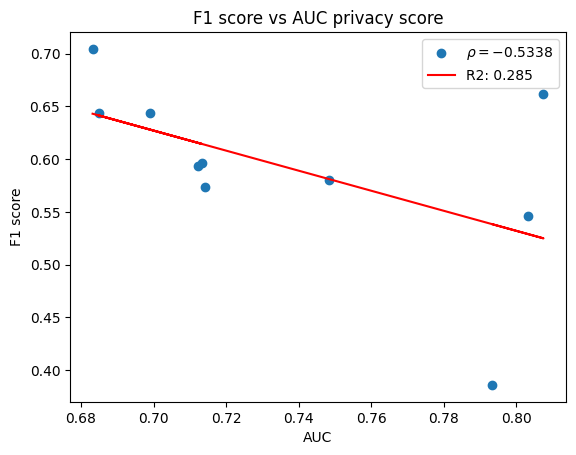

In [77]:
from sklearn.linear_model import LinearRegression
import numpy as np

aucs = []
f1_scores = []
recalls = []
precisions = []
for cr, attacks_result in zip(classification_reports, attacks_results_list):
    x = attacks_result.get_result_with_max_auc().roc_curve.fpr
    y = attacks_result.get_result_with_max_auc().roc_curve.tpr
    auc = metrics.auc(x, y)
    f1_score = cr['1']['f1-score']
    recall = cr['1']['recall']
    precision = cr['1']['precision']

    aucs.append(auc)
    f1_scores.append(f1_score)
    recalls.append(recall)
    precisions.append(precision)

aucs = np.array(aucs).reshape(-1, 1)
linear_model = LinearRegression()
linear_model.fit(aucs, f1_scores)

rho = np.corrcoef(aucs.flatten(), f1_scores)[0, 1]
r2 = linear_model.score(aucs, f1_scores)

fig = plt.figure()
plt.title('F1 score vs AUC privacy score')
plt.scatter(aucs, f1_scores)
plt.plot(aucs, linear_model.predict(aucs), color='red')
plt.legend([fr'$\rho = {rho:.4f}$', f'R2: {r2:.3f}'])
plt.xlabel('AUC')
plt.ylabel('F1 score')
plt.show()

In [80]:
for i, model in enumerate(models):
    model.save(f'model/varying_dataset_sizes/model_{(i+1)*10}.h5')

c:\Users\Albert Salles\anaconda3\envs\ds\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [94]:
import pickle

res = {}
for i, ar in enumerate(attacks_results_list):
    ar_res = attacks_results_list[i].get_result_with_max_auc()
    res[i] = ar_res

with open('model/varying_dataset_sizes/attacks_results.pkl', 'wb') as f:
    pickle.dump(res, f)

In [95]:
res = pickle.load(open('model/varying_dataset_sizes/attacks_results.pkl', 'rb'))

In [14]:
from keras.models import load_model

models = [load_model(f'model/varying_dataset_sizes/model_{i*10}.h5') for i in range(1, 11)]

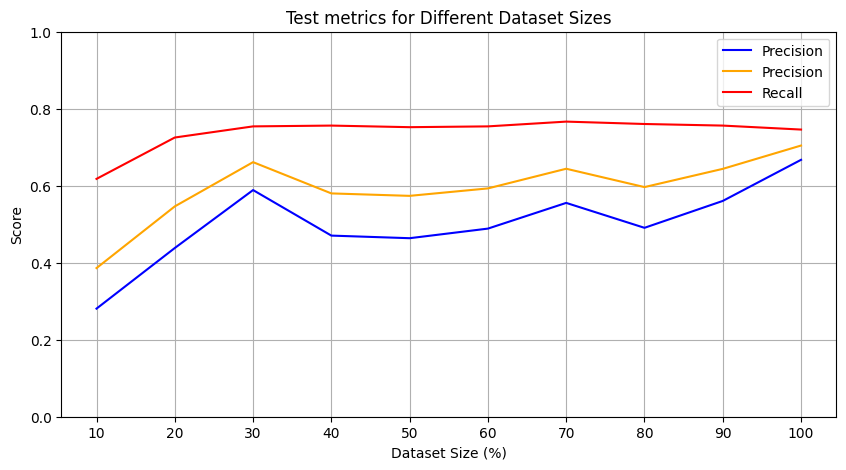

In [103]:
import matplotlib.pyplot as plt

# Plot the results for varying sequence lengths
fig, ax = plt.subplots(1, 1, figsize=(10, 5))

dataset_sizes = [i*10 for i in range(1, 11)]

ax.plot(precisions, label='Precision', color='blue')
ax.plot(f1_scores, label='Precision', color='orange')
ax.plot(recalls, label='Recall', color='red')
ax.set_xlabel('Dataset Size (%)')
ax.set_ylabel('Score')
ax.set_ylim(0, 1)
ax.set_xticks(range(10), dataset_sizes) 
ax.set_title('Test metrics for Different Dataset Sizes') 
ax.legend()
ax.grid(True)
plt.show()


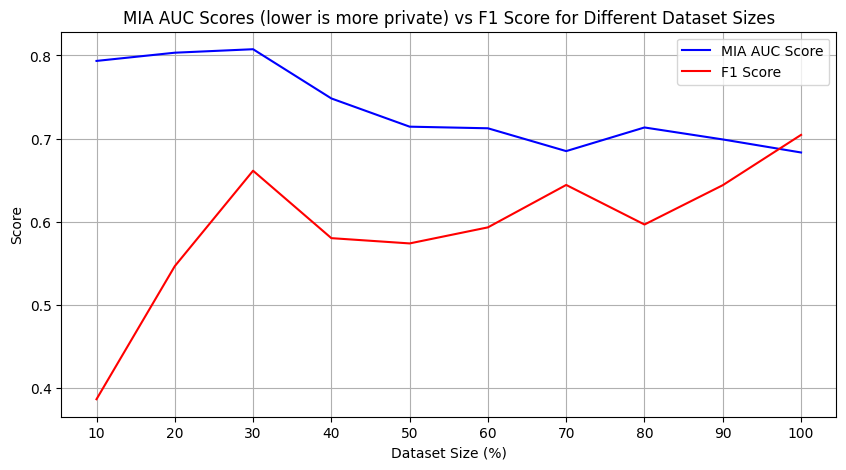

In [102]:
import matplotlib.pyplot as plt

# Plot the results for varying sequence lengths
fig, ax = plt.subplots(1, 1, figsize=(10, 5))

dataset_sizes = [i*10 for i in range(1, 11)]

ax.plot(aucs, label='MIA AUC Score', color='blue')
ax.plot(f1_scores, label='F1 Score', color='red')
ax.set_xlabel('Dataset Size (%)')
ax.set_ylabel('Score')
ax.set_xticks(range(10), dataset_sizes) 
ax.set_title('MIA AUC Scores (lower is more private) vs F1 Score for Different Dataset Sizes')
ax.legend()
ax.grid(True)
plt.show()


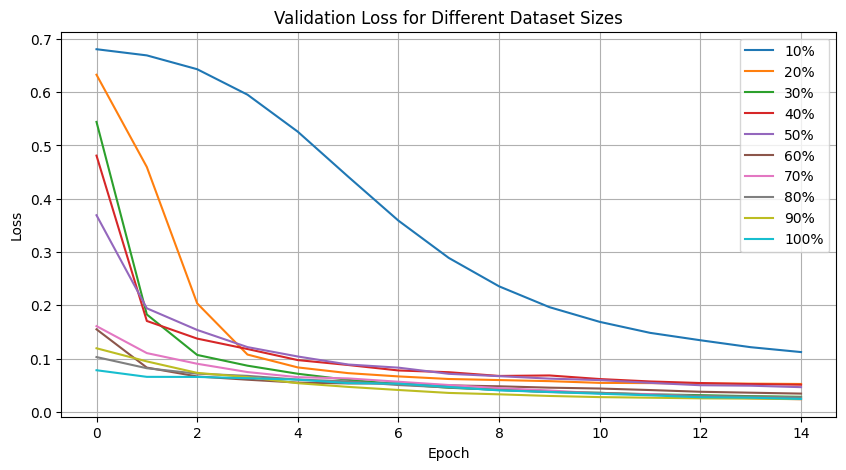

In [107]:
plt.figure(figsize=(10, 5))
for i, h in enumerate(hists):
    plt.plot(h.history['val_loss'], label=f'{(i+1)*10}%')
plt.title('Validation Loss for Different Dataset Sizes')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

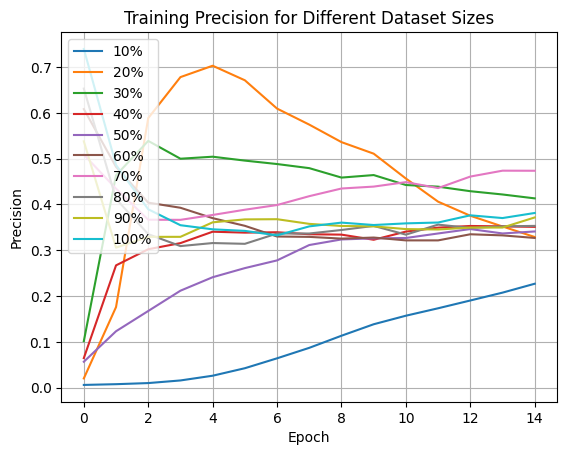

In [105]:
plt.figure()
for i, h in enumerate(hists):
    plt.plot(h.history['val_precision'], label=f'{(i+1)*10}%')
plt.title('Training Precision for Different Dataset Sizes')
plt.xlabel('Epoch')
plt.ylabel('Precision')
plt.legend()
plt.grid(True)
plt.show()

In [16]:
from scipy.stats import pearsonr
from sklearn.metrics import r2_score

dataset_sizes = [i * 10 for i in range(1, 11)] 

# Pearson correlation
pearson_corr, p_value = pearsonr(dataset_sizes, auc_scores) 


print(f"Pearson correlation: {pearson_corr:.4f} (p-value: {p_value:.4f})")

Pearson correlation: -0.0945 (p-value: 0.7952)


In [17]:
from sklearn.linear_model import LinearRegression
import numpy as np

X = np.array(dataset_sizes).reshape(-1, 1)
y = np.array(auc_scores)

# Fit linear regression
model = LinearRegression().fit(X, y)

# Get R² score
r2 = model.score(X, y)
print(f"R² score: {r2:.4f}")

R² score: 0.0089
